In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))
!cp ../input/sample_submission.csv  /kaggle/working/sample_submission.csv
# Any results you write to the current directory are saved as output.

['train.csv', 'sample_submission.csv', 'test.csv']


# The LeNet5 architecture implemented in Keras

###### The LeNet5 model is a Convoutional Neural Network with 5 layers and works exceptionally well in recognizing handwritten digits.
###### Below is the architecture of the LeNet5 neural network

![LeNet5](https://indoml.files.wordpress.com/2018/03/lenet-52.png)

In [2]:
# Importing required libraries
import pandas as pd
import os
import numpy

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

sns.set_style('whitegrid')

from keras import models, layers
from keras.utils.training_utils import multi_gpu_model

Using TensorFlow backend.


## Building and training the model with Keras

In [3]:
# defining a function to create the LeNet5 network
def LeNet5(input_shape, activation='tanh'):
    
    """
    Build and return the LeNet5 CNN
    with tanh activation in the Convolutional layers
    and ReLu activation in the Dense layers
    """
    
    # taking the input and assigning it to X_input
    X_input = layers.Input(shape=input_shape)
    
    # padding zeros to make the size of the 
    X = layers.ZeroPadding2D((2, 2))(X_input)
    
    # adding a Convolutional layer of 6 filters of size 5x5
    X = layers.Conv2D(filters=6, kernel_size=(5, 5), activation=activation)(X)
    
    # adding an average pool layer of filter size 2x2 and stride size 2(helps in decreasing size of "volume" in case it is too big)
    X = layers.AveragePooling2D(pool_size=(2, 2), strides=(2, 2))(X)
    
    # adding another Convolutional layer with 16 filters of size 5x5
    X = layers.Conv2D(filters=16, kernel_size=(5, 5), activation=activation)(X)
    
    # another average pool layer of filter size 2x2 and stride size 2
    X = layers.AveragePooling2D(pool_size=(2, 2), strides=(2, 2))(X)
    
    # flattening the "volume" to pass to the next Dense layer
    X = layers.Flatten()(X)
    
    # a Dense layer that outputs a vector with 120 neurons and applies the relu activation
    X = layers.Dense(120, activation='relu')(X)
    
    # a dense layer that outputs a vector with 84 neurons and applies the relu activation
    X = layers.Dense(84, activation='relu')(X)
    
    # the final Dense layer with 10 neurons and applies the softmax activation which gives the probability of the current example belonging to each of the classes (10 in our case)
    X = layers.Dense(10, activation='softmax')(X)
    
    # making a keras model object to return when the function is called
    model = models.Model(inputs=X_input, outputs=X)
    
    # return the model
    return model

## Reading the training data set

In [4]:
# reading the dataset train.csv
train_df = pd.read_csv("../input/train.csv", header=0)

# creating one hot encoded vectors for the label column to train the network
labels = pd.get_dummies(train_df['label']).values

# assigning the pixel intensities to inputs
inputs = train_df.iloc[:, 1:]

# looping over all examples and reshaping them to 28x28 numpy arrays to feed into the network
inputs_format = []
for _, row in inputs.iterrows():
    inputs_format.append(row.values.reshape((28, 28, 1)).tolist())

inputs_format = numpy.array(inputs_format)
print(inputs_format.shape)

(42000, 28, 28, 1)


## Visualizing distribution of number of examples in each class

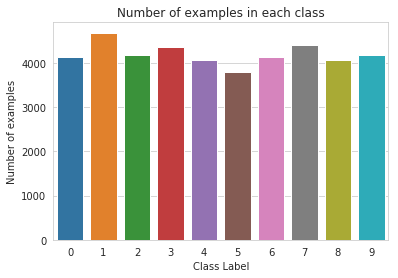

In [5]:
counts = train_df.loc[:, ['label']].sort_values('label').label.value_counts().to_dict()
ordered_keys = [i for i in range(10)]
ordered_values = [counts[i] for i in range(10)]
sns.barplot(x=ordered_keys, y=ordered_values)
_ = plt.xticks(ordered_keys)
_ = plt.xlabel('Class Label')
_ = plt.ylabel('Number of examples')
_ = plt.title('Number of examples in each class')

## Training the model and saving it

In [6]:
# making the model
lenet5 = LeNet5(inputs_format[0].shape) # inputs_format[0].shape is (28, 28, 1)

# compiling the model with adam optimizer and categorical_crossentropy loss function along with the accuracy metric
lenet5.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# training the model with the processed data and splitting the dataset with 30% of the samples in the validation data set
history = lenet5.fit(x=inputs_format, y=labels, validation_split=0.3, epochs=30)

# saving the model in an h5 file
lenet5.save('lenet5_mnist.h5')

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Train on 29399 samples, validate on 12601 samples
Epoch 1/30
29399/29399 [==============================] - 9s 317us/step - loss: 0.2194 - acc: 0.9335 - val_loss: 0.0854 - val_acc: 0.9734
Epoch 2/30
29399/29399 [==============================] - 4s 150us/step - loss: 0.0789 - acc: 0.9757 - val_loss: 0.0636 - val_acc: 0.9803
Epoch 3/30
29399/29399 [==============================] - 4s 148us/step - loss: 0.0570 - acc: 0.9817 - val_loss: 0.0626 - val_acc: 0.9802
Epoch 4/30
29399/29399 [==============================] - 4s 149us/step - loss: 0.0486 - acc: 0.9845 - val_loss: 0.0847 - val_acc: 0.9740
Epoch 5/30
29399/29399 [==============================] - 4s 148us/step - loss: 0.0409 - acc: 0.9864 - val_loss: 0.0589 - val_acc: 0.9837
Epoch 6/30
29399/29399 [==============================] - 5s 158us/step - loss: 0.0322 - acc: 0.9889 - val_loss: 0.0569 - val_acc: 0.9836
Ep

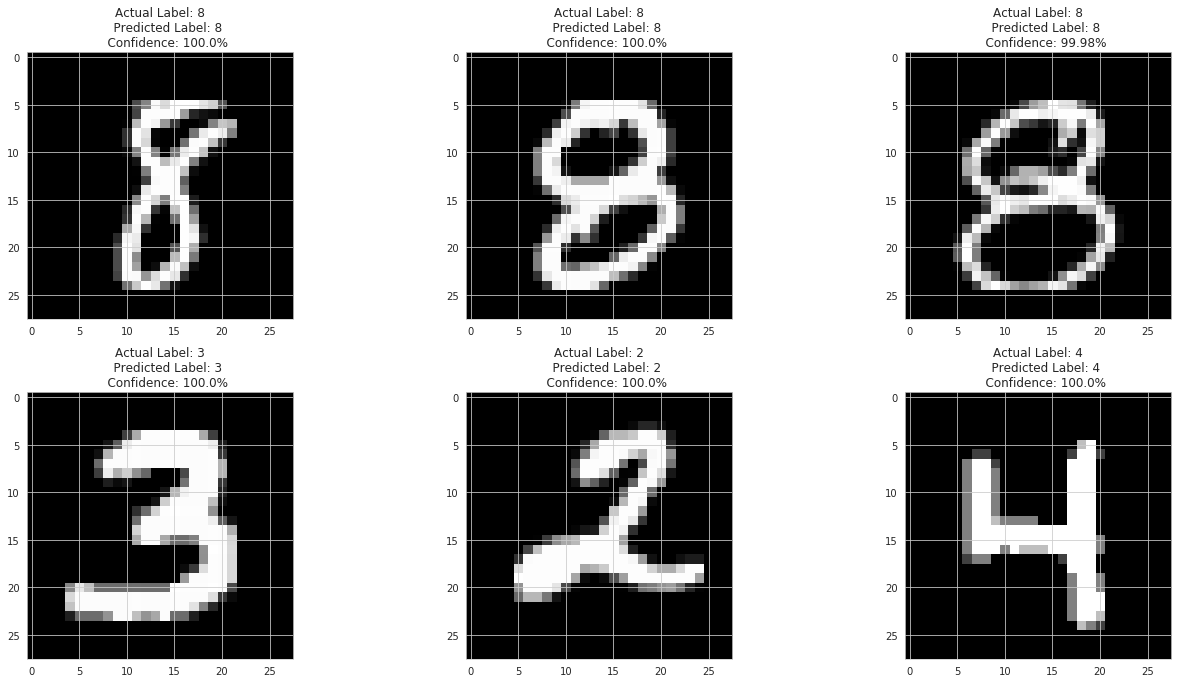

In [7]:
fig, ax = plt.subplots(2, 3, figsize=(19.2, 9.6))
for ind in range(1, 7):
    rand_ind = numpy.random.randint(0, 42000)
    rand_img = inputs.iloc[rand_ind, :]
    label = train_df['label'][rand_ind]
    
    pred_proba = lenet5.predict(numpy.array([rand_img.values.reshape((28, 28, 1)).tolist()]))
    pred_label = numpy.argmax(pred_proba, axis=1)[0]
    confidence = round(numpy.max(pred_proba, axis=1)[0] * 100, 2)
    
    plot_title = f"""Actual Label: {label}
    Predicted Label: {pred_label}
    Confidence: {confidence}%"""
    
    plt.subplot(2, 3, ind)
    plt.imshow(rand_img.values.reshape(28, 28), cmap='gray')
    plt.title(plot_title)

plt.tight_layout()

## Reading the test data to predict the labels

In [8]:
# importing the test data from test.csv
test_df = pd.read_csv("../input/test.csv", header=0)

# looping over all examples and reshaping them to 28x28 numpy arrays to feed into the network
test_inputs_format = []
for _, row in test_df.iterrows():
    test_inputs_format.append(row.values.reshape((28, 28, 1)).tolist())

test_inputs_format = numpy.array(test_inputs_format)
print(test_inputs_format.shape)

(28000, 28, 28, 1)


## Predicting the labels and writing them in the sample_submission file

In [9]:
pred_proba = lenet5.predict(test_inputs_format) # get the probabilities of the examples belonging to each class
pred_labels = numpy.argmax(pred_proba, axis=1) # get the actual class label(index of maximum probability)

# create a pandas Series from pred_labels to feed into the sample_submissions.csv
pred_labels_series = pd.Series(pred_labels)

# read the sample_submission.csv file
submission_df = pd.read_csv(os.path.abspath("sample_submission.csv"), header=0)

# assigning the predicted labels to the Label column
submission_df['Label'] = pred_labels_series

# resetting the index of the csv file
submission_df = submission_df.set_index(['ImageId'])
print(submission_df.head())
# writing back the updated data frame
submission_df.to_csv(os.path.abspath("sample_submission.csv"))

         Label
ImageId       
1            2
2            0
3            9
4            0
5            3


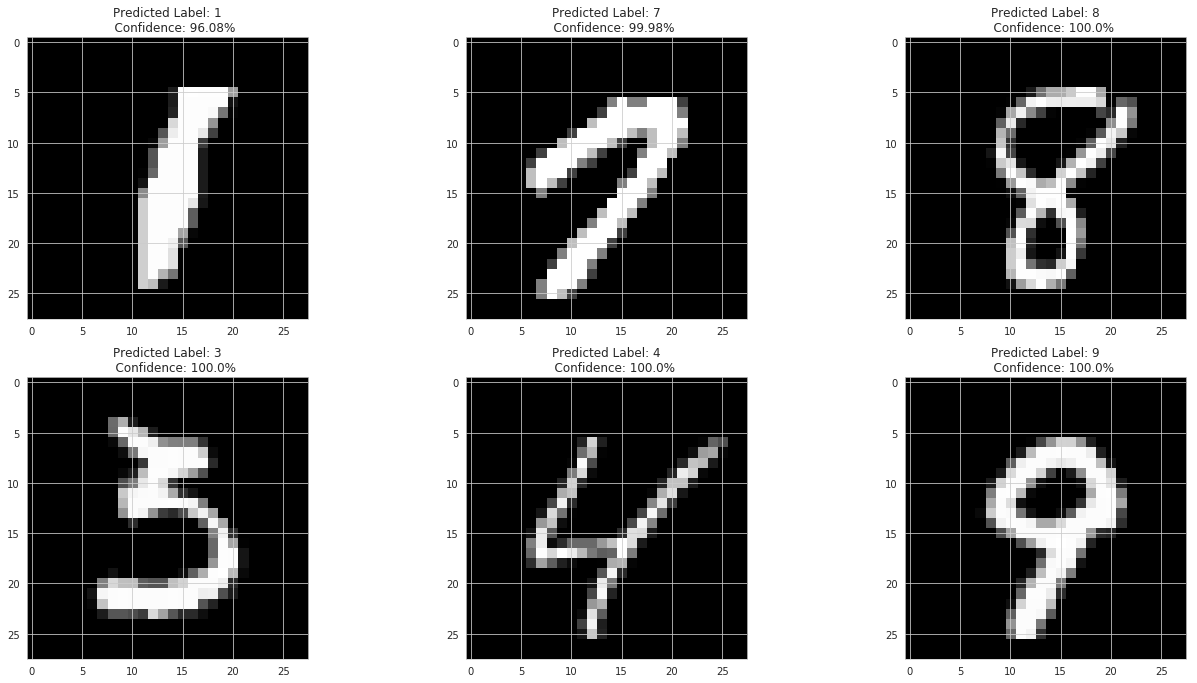

In [10]:
fig, ax = plt.subplots(2, 3, figsize=(19.2, 9.6))
for ind in range(1, 7):
    rand_ind = numpy.random.randint(0, 28000)
    rand_img = test_df.iloc[rand_ind, :]
    
    pred_proba = lenet5.predict(numpy.array([rand_img.values.reshape((28, 28, 1)).tolist()]))
    pred_label = numpy.argmax(pred_proba, axis=1)[0]
    confidence = round(numpy.max(pred_proba, axis=1)[0] * 100, 2)
    
    plot_title = f"""Predicted Label: {pred_label}
    Confidence: {confidence}%"""
    
    plt.subplot(2, 3, ind)
    plt.imshow(rand_img.values.reshape(28, 28), cmap='gray')
    plt.title(plot_title)

plt.tight_layout()

## Plotting the trends in Accuracy and Loss

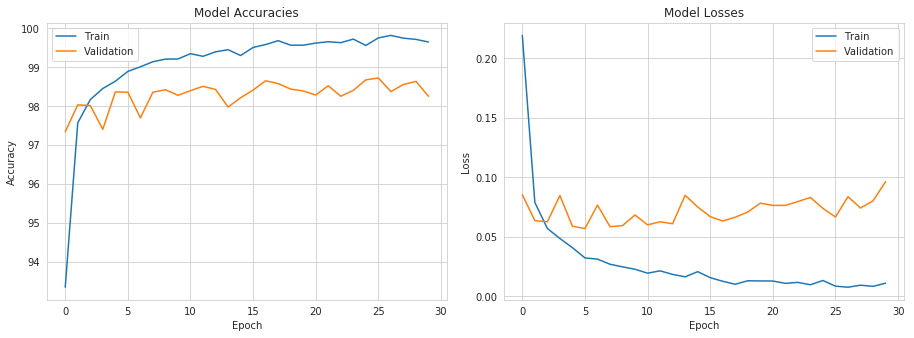

In [11]:
# make a matplotlib figure and subplots
fig, ax = plt.subplots(1, 2, figsize=(12.8, 4.8))

# plot lineplots for train and validation accuracies
sns.lineplot(x=range(len(history.history['acc'])), y=list(map(lambda x: x * 100, history.history['acc'])), ax=ax[0], label='Train')
sns.lineplot(x=range(len(history.history['val_acc'])), y=list(map(lambda x: x * 100, history.history['val_acc'])), ax=ax[0], label='Validation')
# setting other configurations for the plot
ax[0].set_title('Model Accuracies')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Accuracy')
ax[0].legend()

# plot lineplots for train and avlidation losses
sns.lineplot(x=range(len(history.history['loss'])), y=history.history['loss'], ax=ax[1], label='Train')
sns.lineplot(x=range(len(history.history['val_loss'])), y=history.history['val_loss'], ax=ax[1], label='Validation')
# setting other configurations for the plot
ax[1].set_title('Model Losses')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Loss')
ax[1].legend()

_ = plt.tight_layout()